In [1]:
#mnist test

#https://www.kaggle.com/c/digit-recognizer/data

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv("../../mnist_data/train.csv")
test_data = pd.read_csv("../../mnist_data/test.csv")

In [3]:
X = train_data.drop('label',axis=1)
y = train_data['label']

In [4]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
import matplotlib.pyplot as plt


for f in range(0,9):
    plt.subplot(331+f)
    a = X.iloc[f,:].values.reshape(28,28)
    plt.imshow(a,cmap=plt.get_cmap('gray'))
    plt.title(y[f])
    plt.xticks([])
    plt.yticks([])
plt.show()

<Figure size 640x480 with 9 Axes>

In [6]:
y.value_counts() #balance

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [7]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.feature_selection import SelectFromModel

In [9]:
x_train, x_valid,y_train, y_valid = train_test_split(X, y, test_size=0.1)


In [11]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(x_train, y_train)
y_predict=rfc.predict(x_valid)
mae = mean_absolute_error(y_valid, y_predict)

In [12]:
print(mae)

0.13


In [13]:
import seaborn as sns

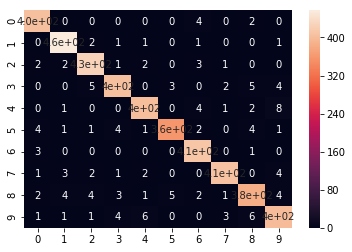

In [14]:
sns.heatmap(confusion_matrix(y_valid, y_predict),annot=True)

In [8]:
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn
import mxnet as mx
import datetime


x_train_pic = x_train.values.reshape(-1,28,28,1)
x_valid_pic = x_valid.values.reshape(-1,28,28,1)
train_dataset = gdata.dataset.ArrayDataset(nd.array(x_train_pic), nd.array(y_train.values))
valid_dataset = gdata.dataset.ArrayDataset(nd.array(x_valid_pic), nd.array(y_valid.values))


NameError: name 'x_train' is not defined

In [140]:
def get_net(ctx):
    finetune_net= model_zoo.vision.resnet18_v1()
    finetune_net.output = nn.Dense(10)
    # need to put the parameters on to model cpu or gpu()
    #finetune_net.features.initialize(init.Xavier(), ctx=ctx)
    #finetune_net.collect_params().reset_ctx(ctx)
    return finetune_net

In [158]:
#If sparse_label is True (default), label should contain integer category indicators:
loss = gloss.SoftmaxCrossEntropyLoss()

# Use the get_loss to get the loss for the valid data, can not use the net(X) directly because we will not use the
# old output layer
def get_loss(data, net, ctx):
    l=0
    for X, y in data:
        output=net(X.as_in_context(ctx))
        l += loss(output, y.as_in_context(ctx)).mean().asscalar()
    return l/len(data)

In [159]:
#image transformation, resize, crop, flip and nomorlize
transform_train = gdata.vision.transforms.Compose([
    gdata.vision.transforms.Resize(40),
    gdata.vision.transforms.RandomResizedCrop(32, scale=(0.64,1), ratio = (1.0,1.0)),
    gdata.vision.transforms.RandomFlipLeftRight(),
    #for ToTensor, check this: https://pytorch.org/docs/0.2.0/_modules/torchvision/transforms.html#ToTensor
    gdata.vision.transforms.ToTensor(),
    gdata.vision.transforms.Normalize([0.4914],
                                      [0.2023])
])


In [160]:
def train(net, train_set, valid_set, lr, wd, num_epochs, lr_decay,lr_period, batch_size, ctx):
    trainer = gluon.Trainer(net.collect_params(),'sgd', {'learning_rate':lr, 'momentum':0.9, 'wd': wd})
    previous_time=datetime.datetime.now()
    
    train_data = gdata.DataLoader(train_set.transform_first(transform_train), batch_size=batch_size)
    valid_data = gdata.DataLoader(valid_set.transform_first(transform_train), batch_size=batch_size)

    for epoch in range(num_epochs):
        train_l = 0
        if epoch > 0 and epoch%lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        for X, y in train_data:
            #print(X.shape)
            with autograd.record():
                output = net(X.as_in_context(ctx))
                #l = loss(output,y.astype('float32').as_in_context(ctx))
                l = loss(output,y.as_in_context(ctx))

            l.backward()
            #print(l)
            train_l += l.mean().asscalar()
            trainer.step(batch_size)
            
        current_time=datetime.datetime.now()
        
        h,reminder=divmod((current_time-previous_time).seconds, 3600)
        m,s = divmod(reminder, 60)
        time_s = "time: %02d:%02d:%02d" %(h,m,s)
        print(time_s)
        #print(train_l)
        if epoch % 1 == 0:
            if valid_data is not None:  
                print("epoch %d, train_loss %f, valid_loss %f, learning_rate %f, time %s"%
                      (epoch, train_l/len(train_data), get_loss(valid_data, net, ctx), 
                      trainer.learning_rate, time_s))
            else:
                print("epoch %d, train_loss %f, learning_rate %f, time %s"%
                      (epoch, train_l/len(train_data),trainer.learning_rate,time_s))

In [ ]:
ctx, num_epochs, lr, wd, batch_size = mx.gpu(0), 100, 0.0001, 1e-4, 20
lr_period, lr_decay, net = 20, 0.1, get_net(ctx)
net.hybridize()
net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
train(net, train_dataset, valid_dataset, lr, wd, num_epochs, 
      lr_decay, lr_period, batch_size, ctx)

time: 00:01:08
epoch 0, train_loss 0.585165, valid_loss 0.211504, learning_rate 0.000100, time time: 00:01:08
time: 00:02:20
epoch 1, train_loss 0.241705, valid_loss 0.144605, learning_rate 0.000100, time time: 00:02:20
time: 00:03:32
epoch 2, train_loss 0.177874, valid_loss 0.117182, learning_rate 0.000100, time time: 00:03:32
time: 00:04:43
epoch 3, train_loss 0.146303, valid_loss 0.101100, learning_rate 0.000100, time time: 00:04:43
time: 00:05:55
epoch 4, train_loss 0.121864, valid_loss 0.095863, learning_rate 0.000100, time time: 00:05:55
time: 00:07:07
epoch 5, train_loss 0.106701, valid_loss 0.094851, learning_rate 0.000100, time time: 00:07:07
time: 00:08:19
epoch 6, train_loss 0.096321, valid_loss 0.077087, learning_rate 0.000100, time time: 00:08:19
time: 00:09:31
epoch 7, train_loss 0.088829, valid_loss 0.079756, learning_rate 0.000100, time time: 00:09:31
time: 00:10:42
epoch 8, train_loss 0.083035, valid_loss 0.076282, learning_rate 0.000100, time time: 00:10:42
time: 00:1